In [1]:
import geopandas as gpd
import pandas as pd
import contextily as cx
import shapely.geometry
import numpy as np
from shapely.geometry import Polygon
from shapely.wkt import loads
from shapely.geometry import LineString, Point
from shapely.geometry import shape
from datetime import datetime, timezone
import matplotlib.pyplot as plt
from shapely.geometry import shape
from pyproj import Transformer, transform
import sys, os
import math
import matplotlib.colors as colors
pd.set_option('display.max_columns', None)

In [2]:
def createBinningDF(xmin, ymin, xmax, ymax, target_length, target_width):
    # Get bounds of bins
    #xmin, ymin, xmax, ymax = geo_df.total_bounds

    # Using WGS84 with Lat Lon, so width and height must be in degrees.
    # length target (m) / 110000
    # Width  target (m) / 88000
    length = target_length / 110000
    wide = target_width / 88000

    cols = list(np.arange(xmin, xmax + wide, wide))
    rows = list(np.arange(ymin, ymax + length, length))

    polygons = []
    for x in cols[:-1]:
        for y in rows[:-1]:
            polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

    grid = gpd.GeoDataFrame({'geometry':polygons}, crs="epsg:4326")
    
    return grid


In [6]:
grid_df = createBinningDF(-95.42, 29.66, -95.08, 29.80, 250, 250)

In [9]:
grid_df['ref'] = np.arange(grid_df.shape[0])

In [10]:
grid_df.head()

,geometry,ref
0,"POLYGON ((-95.42000 29.66000, -95.41716 29.660...",0
1,"POLYGON ((-95.42000 29.66227, -95.41716 29.662...",1
2,"POLYGON ((-95.42000 29.66455, -95.41716 29.664...",2
3,"POLYGON ((-95.42000 29.66682, -95.41716 29.666...",3
4,"POLYGON ((-95.42000 29.66909, -95.41716 29.669...",4


In [8]:
grid_df.explore()

In [11]:
len(grid_df)

7440

In [27]:
def gen_avg(n, expected_avg, a, b):
    #while True:
    l = np.random.randint(a, b, size=n)
    avg = np.mean(l)
    #if avg == expected_avg:
    return l[0]

grid_df['rsrp'] = grid_df.apply(lambda x: gen_avg(len(x), -80, -144, -50), axis = 1)
grid_df['rsrq'] = grid_df.apply(lambda x: gen_avg(len(x), -5, -20, -10), axis = 1)
grid_df['dl_user_thp (mbps)'] = grid_df.apply(lambda x: gen_avg(len(x), 500, 1, 45), axis = 1)
grid_df['drops'] = grid_df.apply(lambda x: gen_avg(len(x), 100, 0, 6), axis = 1)
grid_df['quality_score'] = grid_df.apply(lambda x: gen_avg(len(x), 100, 5, 80) / 100.0, axis = 1)
grid_df['coverage_score'] = grid_df.apply(lambda x: gen_avg(len(x), 100, 5, 80) / 100.0, axis = 1)
grid_df['throughput_score'] = grid_df.apply(lambda x: gen_avg(len(x), 100, 5, 80) / 100.0, axis = 1)

grid_df.head()

,geometry,ref,rsrp,rsrq,dl_user_thp (mbps),drops,quality_score,coverage_score,throughput_score
0,"POLYGON ((-95.42000 29.66000, -95.41716 29.660...",0,-52,-16,6,3,0.72,0.11,0.71
1,"POLYGON ((-95.42000 29.66227, -95.41716 29.662...",1,-72,-12,32,1,0.60,0.78,0.52
2,"POLYGON ((-95.42000 29.66455, -95.41716 29.664...",2,-132,-18,21,3,0.76,0.35,0.31
3,"POLYGON ((-95.42000 29.66682, -95.41716 29.666...",3,-85,-18,17,1,0.05,0.34,0.77
4,"POLYGON ((-95.42000 29.66909, -95.41716 29.669...",4,-139,-20,10,4,0.15,0.36,0.32


<Axes: >

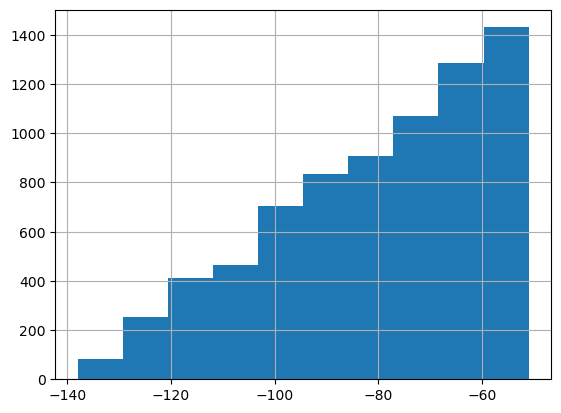

In [18]:
grid_df['rsrp'].hist()

In [28]:
grid_df.to_file("grid-kpis.json")